# Clusters

## Loading Modules, Data and Model

In [1]:
import csv
import pickle as pkl

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import TruncatedSVD 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances, silhouette_score, calinski_harabasz_score, davies_bouldin_score

plt.rcParams["figure.figsize"] = [10.50, 10.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
mod_paths = sorted([str(mod_path) for mod_path in Path(models_dir).glob('*.model')])[1:] # removing 1e5 model

In [3]:
def export_results(path, data=None):
    if not path.is_file():
        with open(path, 'w') as file:
            writer = csv.writer(file)
            writer.writerow(data.keys())
            if data is not None:
                writer.writerow(data.values())
    else:
        with open(path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data.values())
            

def load_labels(file):
    with open(file, 'rb') as handle:
            labels = pkl.load(handle)
            
    return labels


def export_labels(labels, file):
    with open(file, 'wb') as handle:
        pkl.dump(labels, handle, protocol=pkl.HIGHEST_PROTOCOL)


def get_kmeans(data, size, distance, n_clusters):
    labels_file = Path(data_dir, f'labels_km_{size}_{n_clusters:02d}_{distance}.pkl')
    if labels_file.is_file():
        labels = load_labels(labels_file)
    else:
        km = KMeans(n_clusters=n_clusters)
        km.fit(data)
        labels = km.labels_.tolist()
        export_labels(labels, labels_file)
        
    return labels


def get_dbscan(data, size, distance, epsilon, min_pts):
    labels_file = Path(data_dir, f'labels_dbscan_{size}_{epsilon}_{min_pts:02d}_{distance}.pkl')
    if labels_file.is_file():
        labels = load_labels(labels_file)
    else:
        db = DBSCAN(eps=epsilon,
                    min_samples=min_pts,
                    metric=distance,
                    n_jobs=12
                   ).fit(data)
        labels = db.labels_
        export_labels(labels, labels_file)
    
    return labels


def get_hdbscan(data, size, distance, min_clt_size, min_samples):
    labels_file = Path(data_dir, f'labels_hdbscan_{size}_{min_clt_size:02d}_{min_samples:02d}_{distance}.pkl')
    if labels_file.is_file():
        labels = load_labels(labels_file)
    else:
        clusterer = HDBSCAN(min_cluster_size=min_clt_size,
                            min_samples=min_samples,
                            metric=distance,
                            core_dist_n_jobs=12
                           ).fit(data)
        labels = clusterer.labels_
        export_labels(labels, labels_file)
    
    return labels


def evaluate_cluster(data, labels, distance, method, n_clusters=None):
    results = {}
    
    if method != 'km':
        count_clust = Counter(labels)
        n_clusters = len([key for key in count_clust.keys() if key != -1])
        results['n_clusters'] = n_clusters

        if -1 in count_clust:
            n_noise = count_clust[-1]
            results['n_noise'] = n_noise

        clust_data = []
        clust_labs = []
        for i, label in enumerate(labels):
            if label != -1:
                clust_data.append(data[i])
                clust_labs.append(labels[i])
    else:
        clust_data = data
        clust_labs = labels
        n_clusters = n_clusters
        results['n_clusters'] = n_clusters
    
    if len(clust_labs) == n_clusters or n_clusters < 2:
        results.update({'sl_score': None, 'ch_score': None, 'db_score': None})
    else:
        results.update({
            'sl_score': silhouette_score(clust_data, clust_labs, metric=distance),
            'ch_score': calinski_harabasz_score(clust_data, clust_labs),
            'db_score': davies_bouldin_score(clust_data, clust_labs)
        })

    return results


def get_results(data, filename, labels, size, distance, method, **kwargs):
    if method=='km':
        n_clusters = kwargs['n_clusters']
        cls_res = evaluate_cluster(data, labels, distance, method, n_clusters)
    elif method=='dbscan':
        cls_res = evaluate_cluster(data, labels, distance, method)
        cls_res = {'epsilon': kwargs['epsilon'], 'min_pts': kwargs['min_pts']}  | cls_res
    elif method=='hdbscan':
        cls_res = evaluate_cluster(data, labels, distance, method)
        cls_res = {'min_clt_size': kwargs['min_clt_size'], 'min_samples': kwargs['min_samples']}  | cls_res
    
    results = {'distance': distance, 'size': size} | cls_res
    export_results(Path(data_dir, filename + '.csv'), results)

    
def clustering(path_list, method='km', **kwargs):
    if 'distance' not in kwargs:
        distance = 'euclidean'
    else:
        distance = kwargs['distance']
    
    filename = f'eval_{method}_{int(datetime.today().timestamp())}'
    
    for i in range(len(path_list)):
        model = Doc2Vec.load(path_list[i])
        data = model.dv.vectors
        size = path_list[i].split('_')[2]
        
        print(f'Performing {method} and evaluating for {size} points')     
        
        if method=='km':
            for n_clusters in range(kwargs['min_clust'], kwargs['max_clust'] + 1):
                labels = get_kmeans(data, size, distance, n_clusters)
                get_results(data, filename, labels, size, distance, method, n_clusters=n_clusters)
        elif method=='dbscan':
            for epsilon in kwargs['eps_range']:
                for min_pts in kwargs['min_pts_range']:
                    labels = get_dbscan(data, size, distance, epsilon, min_pts)
                    get_results(data, filename, labels, size, distance, method, epsilon=epsilon, min_pts=min_pts)
        elif method=='hdbscan':
            for mcs in kwargs['mcs_range']:
                for min_samples in kwargs['min_samples_range']:
                    labels = get_hdbscan(data, size, distance, mcs, min_samples)
                    get_results(data, filename, labels, size, distance, method, min_clt_size=mcs, min_samples=min_samples)

# HDBSCAN

In [4]:
mcs_range = [mcs for mcs in range(5,21)]
print(mcs_range)
min_samples_range = [ms for ms in range(5,21)]
print(min_samples_range)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [ ]:
clustering(mod_paths[:4], method='hdbscan', mcs_range=mcs_range, min_samples_range=min_samples_range)

Performing hdbscan and evaluating for 10000 points
Performing hdbscan and evaluating for 15000 points
Performing hdbscan and evaluating for 20000 points


In [ ]:
clustering(mod_paths[2:5], method='hdbscan', mcs_range=mcs_range, min_samples_range=min_samples_range)

Performing hdbscan and evaluating for 20000 points


IOStream.flush timed out


In [ ]:
clustering(mod_paths[4:11], method='hdbscan', mcs_range=mcs_range, min_samples_range=min_samples_range)

In [ ]:
clustering(mod_paths[11:], method='hdbscan', mcs_range=mcs_range, min_samples_range=min_samples_range)

# KMeans

In [14]:
clustering(mod_paths, min_clust=2, max_clust=10)

Performing km and evaluating for 10000 points
Performing km and evaluating for 15000 points
Performing km and evaluating for 20000 points
Performing km and evaluating for 25000 points
Performing km and evaluating for 30000 points
Performing km and evaluating for 35000 points
Performing km and evaluating for 40000 points
Performing km and evaluating for 45000 points
Performing km and evaluating for 50000 points
Performing km and evaluating for 55000 points
Performing km and evaluating for 60000 points
Performing km and evaluating for 65000 points
Performing km and evaluating for 70000 points
Performing km and evaluating for 75000 points
Performing km and evaluating for 80000 points
Performing km and evaluating for 85000 points
Performing km and evaluating for 90000 points
Performing km and evaluating for 95000 points


In [15]:
clustering(mod_paths, min_clust=2, max_clust=10, distance='cosine')

Performing km and evaluating for 10000 points
Performing km and evaluating for 15000 points
Performing km and evaluating for 20000 points
Performing km and evaluating for 25000 points
Performing km and evaluating for 30000 points
Performing km and evaluating for 35000 points
Performing km and evaluating for 40000 points
Performing km and evaluating for 45000 points
Performing km and evaluating for 50000 points
Performing km and evaluating for 55000 points
Performing km and evaluating for 60000 points
Performing km and evaluating for 65000 points
Performing km and evaluating for 70000 points
Performing km and evaluating for 75000 points
Performing km and evaluating for 80000 points
Performing km and evaluating for 85000 points
Performing km and evaluating for 90000 points
Performing km and evaluating for 95000 points


In [5]:
res_paths = sorted([str(file) for file in Path(data_dir).glob('km*.csv')])
print(*res_paths, sep='\n')
df = pd.read_csv(res_paths[-1])

/home/miguel/Projects/tfm-nlp/data/interim/km_eval_000.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662929968.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662929971.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662930256.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662930330.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662932634.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662932735.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662933222.csv
/home/miguel/Projects/tfm-nlp/data/interim/km_eval_1662935580.csv


# DBSCAN

In [16]:
min_pts_range = [min_pts for min_pts in range(5,11)]
print(min_pts_range)
eps_range = [round(e*0.01,3) for e in range(50,101,5)]
print(eps_range)
clustering(mod_paths, method='dbscan', eps_range=eps_range, min_pts_range=min_pts_range)

[5, 6, 7, 8, 9, 10]
[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Performing dbscan and evaluating for 10000 points
Performing dbscan and evaluating for 15000 points
Performing dbscan and evaluating for 20000 points
Performing dbscan and evaluating for 25000 points
Performing dbscan and evaluating for 30000 points
Performing dbscan and evaluating for 35000 points
Performing dbscan and evaluating for 40000 points
Performing dbscan and evaluating for 45000 points
Performing dbscan and evaluating for 50000 points
Performing dbscan and evaluating for 55000 points
Performing dbscan and evaluating for 60000 points
Performing dbscan and evaluating for 65000 points
Performing dbscan and evaluating for 70000 points
Performing dbscan and evaluating for 75000 points
Performing dbscan and evaluating for 80000 points
Performing dbscan and evaluating for 85000 points
Performing dbscan and evaluating for 90000 points
Performing dbscan and evaluating for 95000 points


In [33]:
min_pts_range = [min_pts for min_pts in range(5,11)]
print(min_pts_range)
eps_range = [round(e*0.01,3) for e in range(10,41,5)]
print(eps_range)
clustering(mod_paths, method='dbscan', eps_range=eps_range, min_pts_range=min_pts_range, distance='cosine')

[5, 6, 7, 8, 9, 10]
[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
Performing dbscan and evaluating for 10000 points
Performing dbscan and evaluating for 15000 points
Performing dbscan and evaluating for 20000 points
Performing dbscan and evaluating for 25000 points
Performing dbscan and evaluating for 30000 points
Performing dbscan and evaluating for 35000 points
Performing dbscan and evaluating for 40000 points
Performing dbscan and evaluating for 45000 points
Performing dbscan and evaluating for 50000 points
Performing dbscan and evaluating for 55000 points
Performing dbscan and evaluating for 60000 points
Performing dbscan and evaluating for 65000 points
Performing dbscan and evaluating for 70000 points
Performing dbscan and evaluating for 75000 points
Performing dbscan and evaluating for 80000 points
Performing dbscan and evaluating for 85000 points
Performing dbscan and evaluating for 90000 points
Performing dbscan and evaluating for 95000 points


In [30]:
res_paths = sorted([str(file) for file in Path(data_dir).glob('eval_dbscan*.csv')])
print(*res_paths, sep='\n')
df = pd.read_csv(res_paths[-2])

/home/miguel/Projects/tfm-nlp/data/interim/eval_dbscan_1662947362.csv
/home/miguel/Projects/tfm-nlp/data/interim/eval_dbscan_1662982319.csv


In [31]:
df.describe()

,size,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score
count,1188.000000,1188.00000,1188.000000,1188.000000,1188.000000,770.000000,770.000000,770.000000
mean,52500.000000,0.75000,7.500000,1.668350,51452.074916,0.957239,10021.071569,0.377067
std,25951.562034,0.15818,1.708544,0.512136,25430.025043,0.014269,5458.801756,0.138122
min,10000.000000,0.50000,5.000000,1.000000,9791.000000,0.907508,1588.954379,0.152067
25%,30000.000000,0.60000,6.000000,1.000000,29416.500000,0.944721,6073.259130,0.301716
50%,52500.000000,0.75000,7.500000,2.000000,51441.000000,0.960367,8618.081281,0.371099
75%,75000.000000,0.90000,9.000000,2.000000,73508.250000,0.969087,12642.813054,0.426938
max,95000.000000,1.00000,10.000000,3.000000,93166.000000,0.979818,26128.401499,1.330553


In [32]:
df.dropna()

,distance,size,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score
120,euclidean,15000,0.95,5,2,14692,0.962406,1775.816004,0.400869
126,euclidean,15000,1.00,5,2,14691,0.960552,1622.825053,0.423244
127,euclidean,15000,1.00,6,2,14692,0.961196,1588.954379,0.423550
180,euclidean,20000,0.90,5,2,19594,0.969735,3359.397760,0.334454
186,euclidean,20000,0.95,5,2,19588,0.963499,2797.542023,0.376860
...,...,...,...,...,...,...,...,...,...
1183,euclidean,95000,1.00,6,2,93013,0.933847,8809.121864,0.455332
1184,euclidean,95000,1.00,7,2,93013,0.933847,8809.121864,0.455332
1185,euclidean,95000,1.00,8,2,93013,0.933847,8809.121864,0.455332
1186,euclidean,95000,1.00,9,2,93013,0.933847,8809.121864,0.455332


In [34]:
res_paths = sorted([str(file) for file in Path(data_dir).glob('dbscan*.csv')])
print(*res_paths, sep='\n')
df = pd.read_csv(res_paths[-1])

/home/miguel/Projects/tfm-nlp/data/interim/dbscan_eval_000.csv
/home/miguel/Projects/tfm-nlp/data/interim/dbscan_eval_001.csv
/home/miguel/Projects/tfm-nlp/data/interim/dbscan_eval_002.csv
/home/miguel/Projects/tfm-nlp/data/interim/dbscan_eval_1662930523.csv
/home/miguel/Projects/tfm-nlp/data/interim/dbscan_eval_1662930978.csv
/home/miguel/Projects/tfm-nlp/data/interim/dbscan_eval_1662931947.csv
/home/miguel/Projects/tfm-nlp/data/interim/dbscan_eval_1662934073.csv


In [35]:
df

,distance,size,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score
0,cosine,30000,0.1,5,0,10000,NaN,NaN,NaN
1,cosine,30000,0.1,6,0,10000,NaN,NaN,NaN
2,cosine,30000,0.1,7,0,10000,NaN,NaN,NaN
3,cosine,30000,0.1,8,0,10000,NaN,NaN,NaN
4,cosine,30000,0.1,9,0,10000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
79,cosine,35000,0.4,6,38,8265,-0.078346,11.901634,1.797921
80,cosine,35000,0.4,7,30,8426,-0.069461,13.899410,1.776682
81,cosine,35000,0.4,8,22,8572,-0.056611,14.776863,1.872607
82,cosine,35000,0.4,9,16,8720,-0.050897,17.289863,1.880309


In [89]:
df.dropna().sort_values(by='sl_score', ascending=False).head()

,distance,size,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score
15,cosine,30000,0.20,8,2,9978,0.622156,41.406718,0.637305
12,cosine,30000,0.20,5,2,9971,0.614581,38.587049,0.676959
14,cosine,30000,0.20,7,2,9971,0.614581,38.587049,0.676959
13,cosine,30000,0.20,6,2,9971,0.614581,38.587049,0.676959
23,cosine,30000,0.25,10,3,9895,0.487721,62.979466,1.000286


In [88]:
df.dropna().sort_values(by='ch_score', ascending=False).head()

,distance,size,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score
61,cosine,35000,0.25,6,7,14508,0.383846,94.177748,1.316104
64,cosine,35000,0.25,9,6,14544,0.386160,93.552851,1.328955
62,cosine,35000,0.25,7,7,14518,0.384191,92.382797,1.311361
65,cosine,35000,0.25,10,6,14551,0.388371,92.185122,1.309280
63,cosine,35000,0.25,8,7,14531,0.384806,88.715790,1.286564


In [91]:
df.dropna().sort_values(by='db_score', ascending=True).head()

,distance,size,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score
15,cosine,30000,0.2,8,2,9978,0.622156,41.406718,0.637305
12,cosine,30000,0.2,5,2,9971,0.614581,38.587049,0.676959
13,cosine,30000,0.2,6,2,9971,0.614581,38.587049,0.676959
14,cosine,30000,0.2,7,2,9971,0.614581,38.587049,0.676959
54,cosine,35000,0.2,5,4,14859,0.442039,77.939631,0.935099


## Nearest Neighbours estimation

In [16]:
# Min_samples set to ln(number of points)
# number_rows = len(corpus)
# min_samples_set = int(np.ceil(np.log(number_rows)))
# nbrs = NearestNeighbors(n_neighbors=min_samples_set).fit(X)
# distances, indices = nbrs.kneighbors(X)
# distanceDec = sorted(distances[:, min_samples_set-1], reverse=True)
# plt.plot(list(range(1,number_rows + 1)), distanceDec)
# plt.title('Min samples set to ln(number of points)')
# plt.show()

In [6]:
def get_knn_distances(path, distance=None):
    model = Doc2Vec.load(path)
    X = model.dv.vectors
    cardinality = len(X)
    min_samples_set = int(np.ceil(np.log(cardinality)))
    if distance is None:
        nbrs = NearestNeighbors(n_neighbors=min_samples_set).fit(X)
    else:
        nbrs = NearestNeighbors(n_neighbors=min_samples_set, metric=distance).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distanceDec = sorted(distances[:, min_samples_set-1], reverse=True)
    
    return list(range(1, cardinality + 1)), distanceDec

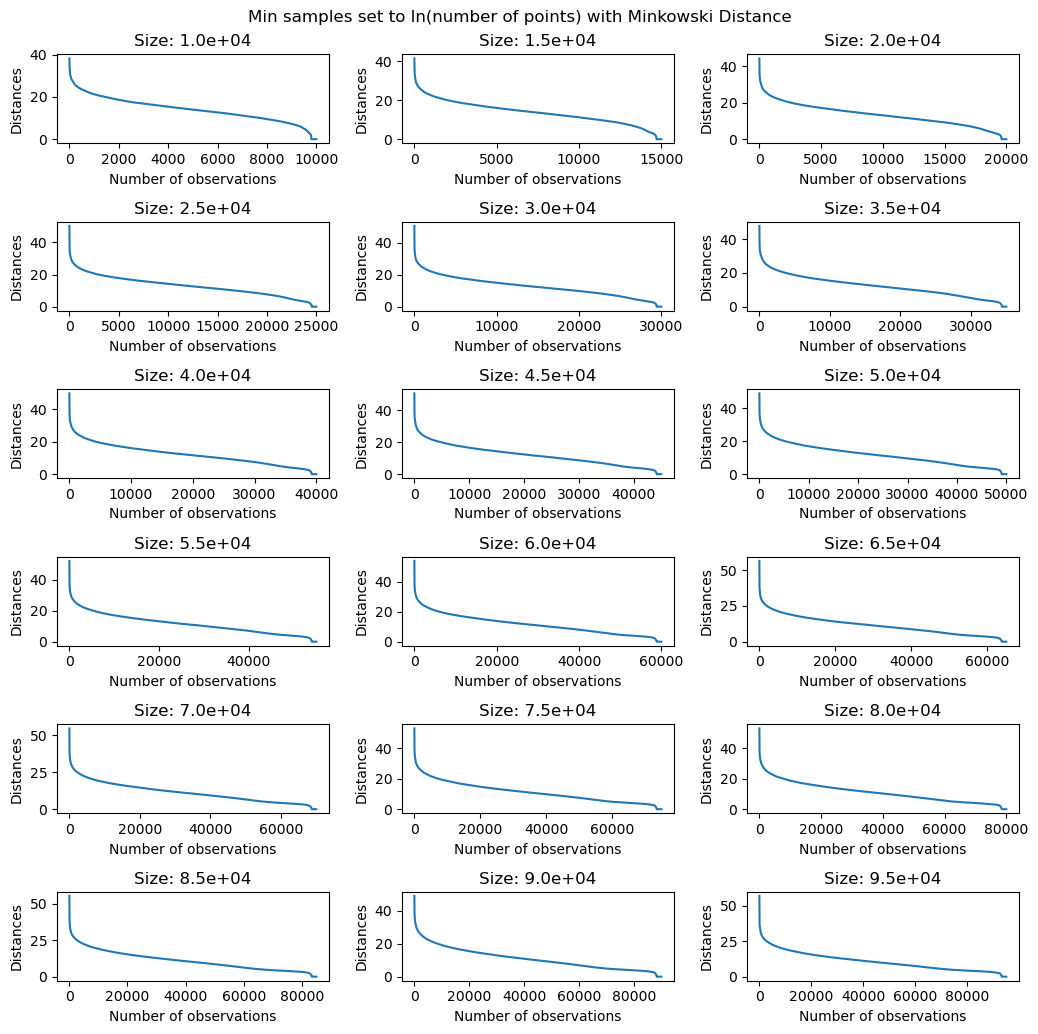

CPU times: user 1h 16min 26s, sys: 13min 54s, total: 1h 30min 20s
Wall time: 17min 57s


In [8]:
%%time
n_rows, n_cols = (6,3)

fig, axes = plt.subplots(n_rows, n_cols)

counter = 0
for row in range(n_rows):
    for col in range(n_cols):
        X, Y = get_knn_distances(mod_paths[counter])
        axes[row][col].plot(X, Y)
        axes[row][col].set_title(f'Size: {int(mod_sizes[counter]):.1e}')
        axes[row][col].set_xlabel('Number of observations')
        axes[row][col].set_ylabel('Distances')
        counter += 1

plt.suptitle('Min samples set to ln(number of points) with Minkowski Distance')
plt.show()

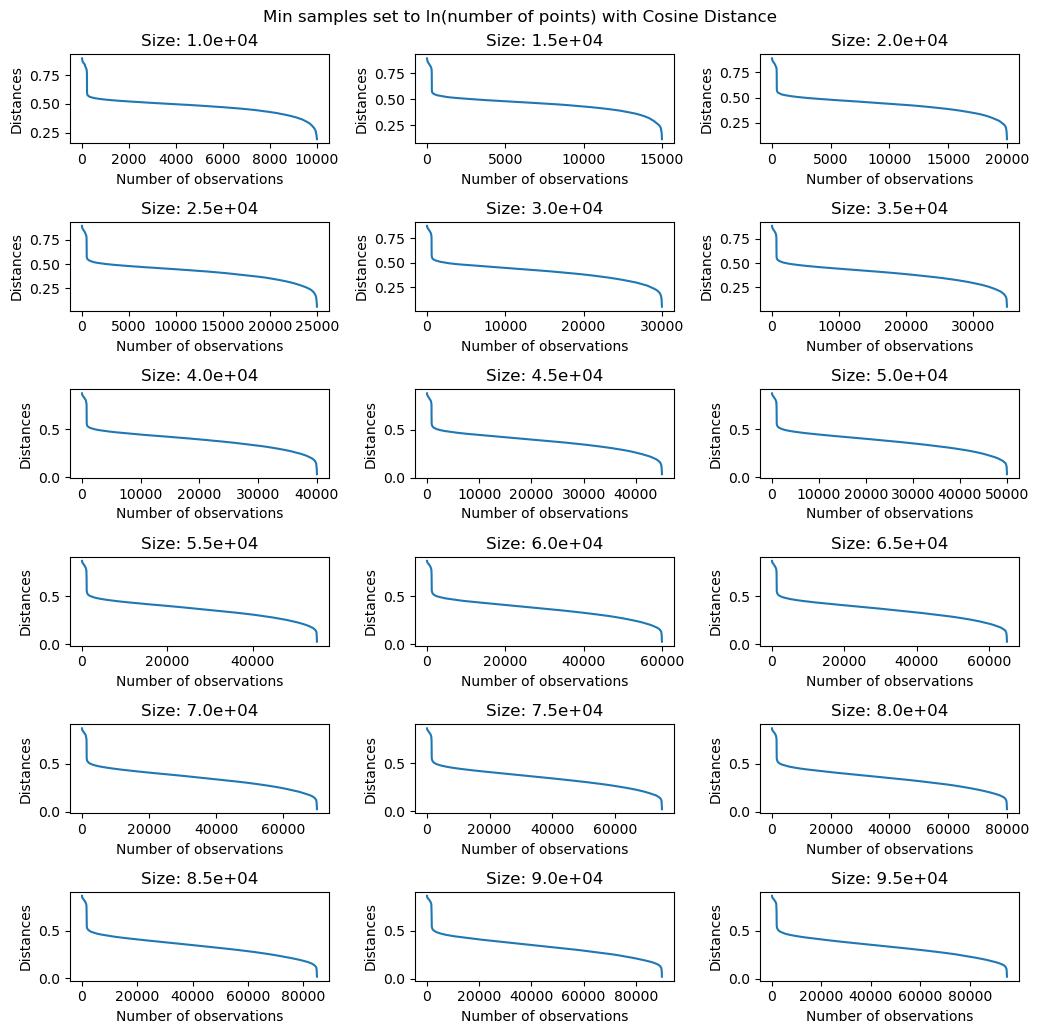

CPU times: user 27min 34s, sys: 8min 54s, total: 36min 28s
Wall time: 11min 45s


In [9]:
%%time
n_rows, n_cols = (6,3)

fig, axes = plt.subplots(n_rows, n_cols)

counter = 0
for row in range(n_rows):
    for col in range(n_cols):
        X, Y = get_knn_distances(mod_paths[counter], distance='cosine')
        axes[row][col].plot(X, Y)
        axes[row][col].set_title(f'Size: {int(mod_sizes[counter]):.1e}')
        axes[row][col].set_xlabel('Number of observations')
        axes[row][col].set_ylabel('Distances')
        counter += 1

plt.suptitle('Min samples set to ln(number of points) with Cosine Distance')
plt.show()

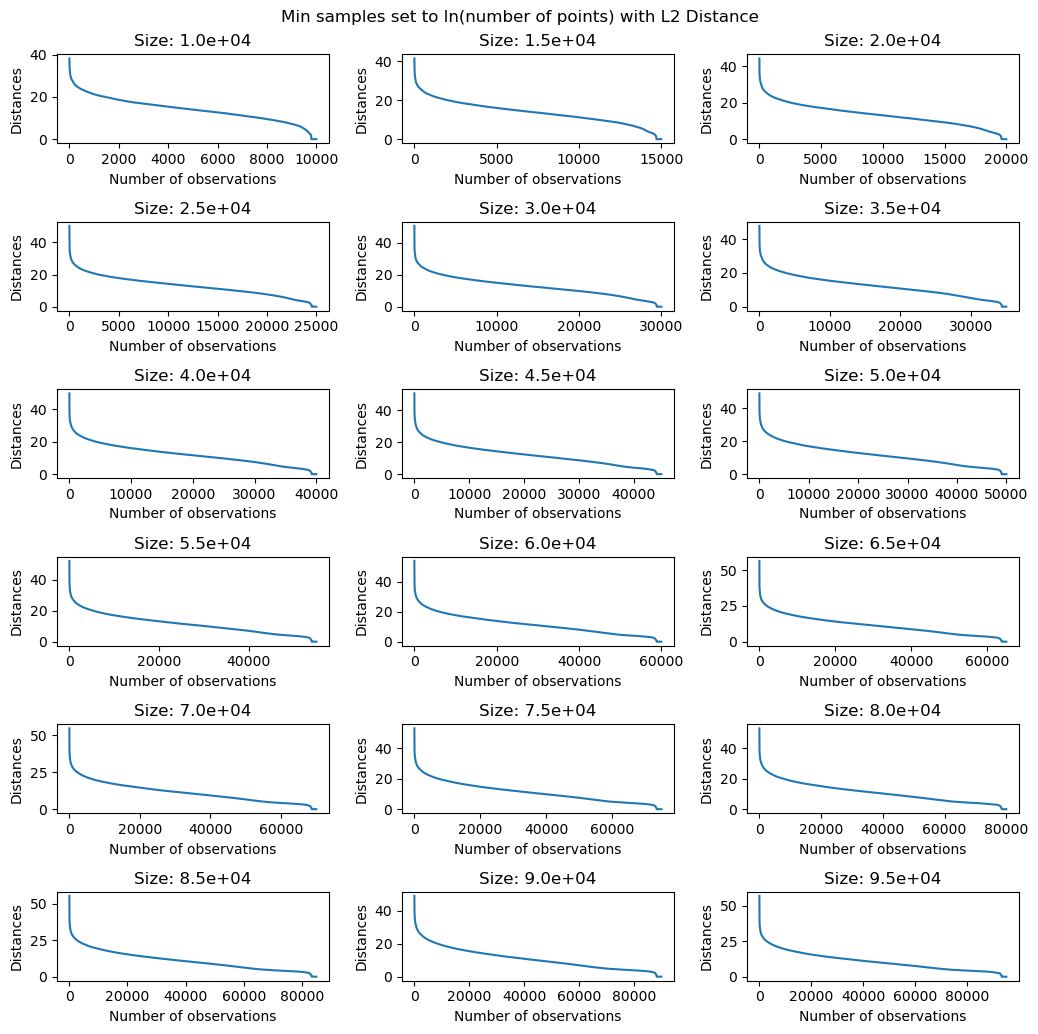

CPU times: user 1h 9min 42s, sys: 12min 7s, total: 1h 21min 49s
Wall time: 16min 39s


In [10]:
%%time
n_rows, n_cols = (6,3)

fig, axes = plt.subplots(n_rows, n_cols)

counter = 0
for row in range(n_rows):
    for col in range(n_cols):
        X, Y = get_knn_distances(mod_paths[counter], distance='l2')
        axes[row][col].plot(X, Y)
        axes[row][col].set_title(f'Size: {int(mod_sizes[counter]):.1e}')
        axes[row][col].set_xlabel('Number of observations')
        axes[row][col].set_ylabel('Distances')
        counter += 1

plt.suptitle('Min samples set to ln(number of points) with L2 Distance')
plt.show()

## KMeans Baseline

In [8]:
# km_eval = {}
# for i in range(3,21):
#     km = KMeans(n_clusters= i)
#     km.fit(X)
#     clusters = km.labels_.tolist()
#     sil_score = metrics.silhouette_score(X, clusters, metric='euclidean')
#     km_eval[i] = sil_score
#     print(f'Clusters: {str(i)} Score: {sil_score}')
# best_cluster = max(km_eval, key=km_eval.get)
# print(f'Best fitted number of clusters: {best_cluster}')

Clusters: 3 Score: 0.06923697888851166
Clusters: 4 Score: 0.02419266663491726
Clusters: 5 Score: 0.011235218495130539
Clusters: 6 Score: 0.0047103026881814
Clusters: 7 Score: -0.03507276996970177
Clusters: 8 Score: -0.04131070524454117
Clusters: 9 Score: -0.0327480211853981
Clusters: 10 Score: -0.04815463721752167
Clusters: 11 Score: -0.05286279320716858
Clusters: 12 Score: -0.06266371160745621
Clusters: 13 Score: -0.04899749904870987
Clusters: 14 Score: -0.059792451560497284
Clusters: 15 Score: -0.06522274017333984
Clusters: 16 Score: -0.08013968169689178
Clusters: 17 Score: -0.07036693394184113
Clusters: 18 Score: -0.059803545475006104
Clusters: 19 Score: -0.07430877536535263
Clusters: 20 Score: -0.07370676100254059
Best fitted number of clusters: 3


In [14]:
# KMeans evaluation results
eval_res = {'size':[], 'clusters':[], 'score': [], 'metric': []}

In [25]:
%%time
min_clust = 3
max_clust = 21
distance = 'euclidean'
for i in range(len(mod_paths)):
    model = Doc2Vec.load(mod_paths[i])
    data = model.dv.vectors
    for n_clust in range(min_clust, max_clust):
        km = KMeans(n_clusters=n_clust)
        km.fit(data)
        clusters = km.labels_.tolist()
        sil_score = silhouette_score(data, clusters, metric=distance)
        if sil_score > 0:
            km_eval_res['size'].append(mod_sizes[i])
            km_eval_res['clusters'].append(n_clust)
            km_eval_res['score'].append(sil_score)
            km_eval_res['metric'].append(distance)
        else:
            continue

In [56]:
def evaluate_cluster(data, labels, **kwargs):
    results = {}
    
    if kwargs['method'] != 'km':
        count_clust = Counter(labels)
        n_clusters = len([key for key in count_clust.keys() if key != -1])
        results['n_clusters'] = n_clusters

        if -1 in count_clust:
            n_noise = count_clust[-1]
            results['n_noise'] = n_noise

        clust_data = []
        clust_labs = []
        for i, label in enumerate(labels):
            if label != -1:
                clust_data.append(data[i])
                clust_labs.append(labels[i])
    else:
        clust_data = data
        clust_labs = labels
        n_clusters = kwargs['n_clusters']
    
    if len(clust_labs) == n_clusters or n_clusters < 2:
        results.update({'sl_score': None, 'ch_score': None, 'db_score': None})
    else:
        results.update({
            'sl_score': silhouette_score(clust_data, clust_labs, metric=kwargs['distance']),
            'ch_score': calinski_harabasz_score(clust_data, clust_labs),
            'db_score': davies_bouldin_score(clust_data, clust_labs)
        })

    return results

In [54]:
def export_results(path, data=None):
    if not path.is_file():
        with open(path, 'w') as file:
            writer = csv.writer(file)
            writer.writerow(data.keys())
            if data is not None:
                writer.writerow(data.values())
    else:
        with open(path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data.values())

In [50]:
def load_labels(file):
    with open(file, 'rb') as handle:
            labels = pkl.load(handle)
    return labels

def export_labels(labels, file):
    with open(file, 'wb') as handle:
        pkl.dump(labels, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [53]:
def get_results(data, labels, **kwargs):
    cls_res = evaluate_cluster(data, labels, kwargs['distance'], kwargs['method'])
    results = {'distance': kwargs['distance'], 'size': kwargs['size']} | cls_res
    export_results(Path(data_dir, filename + '.csv'), results)

In [52]:
def get_kmeans(data, **kwargs):
    labels_file = Path(data_dir, f"{kwargs['method']}_labels_{kwargs['size']}_{n_clust}_{kwargs['distance']}.pkl")
    if labels_file.is_file():
        labels = load_labels(labels_file)
    else:
        km = KMeans(n_clusters=n_clust)
        km.fit(data)
        labels = km.labels_.tolist()
        if save_labels: export_labels(labels, labels_file)
    return labels

In [ ]:
def get_dbscan(data, **kwargs):
    pass

In [ ]:
def get_hdbscan(data, **kwargs):
    pass

In [ ]:
def clustering(path_list, method='km', save_labels=True, **kwargs):
    if 'distance' not in kwargs:
        distance = 'euclidean'
    else:
        distance = kwargs['distance']
    
    for i in range(len(path_list)):
        model = Doc2Vec.load(mod_paths[i])
        data = model.dv.vectors
        size = path_list[i].split('_')[2]
        
        print(f'Evaluating for {size} points')
        
        if method=='km':
            for n_clusters in range(kwargs['min_clust'], kwargs['max_clust']):
                labels = get_kmeans(data, n_clusters)
        elif method=='dbscan':
            pass
        elif method=='hdbscan':
            pass
        
        for n_clust in range(min_clust, max_clust):
            labels_file = Path(data_dir, f'{method}_labels_{size}_{n_clust}_{distance}.pkl')             
            labels = load_labels(labels_file)
            else:
                km = KMeans(n_clusters=n_clust)
                km.fit(data)
                labels = km.labels_.tolist()
                if save_labels: export_labels(labels, labels_file)
            
            cls_res = eval_cluster(data, labels, distance)
            results = [size distance] + cls_res
            export_results(Path(data_dir, filename + '.csv'), results)

In [ ]:
def eval_cluster(data, labels, distance='euclidean'):
    results = []
    
    count_clust = Counter(labels)
    n_clusters = len([key for key in count_clust.keys() if key != -1])
    results.append(n_clusters)
    
    if -1 in count_clust:
        n_noise = count_clust[-1]
        results.append(n_noise)
    
    clust_data = []
    clust_labs = []
    for i, label in enumerate(labels):
        if label != -1:
            clust_data.append(data[i])
            clust_labs.append(labels[i])
    
    if len(clust_labs) == len(labels) or n_clusters < 2:
        results += [None] * 3
    else:
        results.append(silhouette_score(clust_data, clust_labs, metric=distance))
        results.append(calinski_harabasz_score(clust_data, clust_labs))
        results.append(db_score = davies_bouldin_score(clust_data, clust_labs))

    return results


def export_results(path, data=None):
    if not path.is_file():
        with open(path, 'w') as file:
            writer = csv.writer(file)
            writer.writerow(['size', 'n_clusters', 'sil_score', 'distance'])
            if data is not None:
                writer.writerow(data)
    else:
        with open(path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data)


def km_eval(path_list, min_clust, max_clust, distance='euclidean', filename='km_eval', save_labels=True):
    for i in range(len(path_list)):
        model = Doc2Vec.load(mod_paths[i])
        data = model.dv.vectors
        size = path_list[i].split('_')[2]
        
        print(f'Evaluating for {size} points')
        
        for n_clust in range(min_clust, max_clust):
            labels_files = Path(data_dir, f'km_labels_{size}_{n_clust}_{distance}.pkl')             
            if labels_files.is_file():
                with open(labels_files, 'rb') as handle:
                    labels = pkl.load(handle)
            else:
                km = KMeans(n_clusters=n_clust)
                km.fit(data)
                labels = km.labels_.tolist()
                if save_labels:
                    with open(labels_files, 'wb') as handle:
                        pkl.dump(labels, handle, protocol=pkl.HIGHEST_PROTOCOL)
            
            cls_res = eval_cluster(data, labels, distance)
            results = [size, n_clust, distance] + cls_res
            export_results(Path(data_dir, filename + '.csv'), results)

In [8]:
results = []

In [27]:
# Max for 5 clusters
km = KMeans(n_clusters= best_cluster)
km.fit(X)
clusters = km.labels_.tolist()

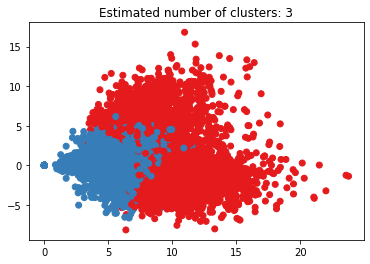

In [55]:
# Plotting KMeans
svd = TruncatedSVD(n_components = 2)
reduced_data = svd.fit_transform(X)
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=[plt.cm.Set1(float(i) /10) for i in clusters])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## DBSCAN

In [5]:
def eval_cluster(data, labels, distance='euclidean'):
    count_clust = Counter(labels)
    n_clusters = len([key for key in count_clust.keys() if key != -1])
    n_noise = count_clust[-1]
    clust_data = []
    clust_labs = []
    for i, label in enumerate(labels):
        if label != -1:
            clust_data.append(data[i])
            clust_labs.append(labels[i])
    if len(clust_labs) == len(labels) or n_clusters < 2:
        sil_score = None
        ch_score = None
    else:
        sil_score = silhouette_score(clust_data, clust_labs, metric=distance)
        ch_score = calinski_harabasz_score(clust_data, clust_labs)

    return [n_clusters, n_noise, sil_score, ch_score]

In [11]:
def export_results(path, data=None):
    if not path.is_file():
        with open(path, 'w') as file:
            writer = csv.writer(file)
            writer.writerow(['size', 'min_pts', 'eps', 'n_cluster', 'n_noise', 'sil_score', 'distance'])
            if data is not None:
                writer.writerow(data)
    else:
        with open(path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(data)

In [12]:
def dbscan_eval(path_list, min_pts_range, eps_range, distance='euclidean', filename='dbscan_eval', save_labels=True):
    for i in range(len(path_list)):
        model = Doc2Vec.load(path_list[i])
        data = model.dv.vectors
        size = path_list[i].split('_')[2]
        
        print(f'Evaluating for {size} points')
        
        for epsilon in eps_range:
            for min_pts in min_pts_range:
                # print(epsilon, min_pts)
                labels_files = Path(data_dir, f'dbscan_labels_{size}_{min_pts}_{epsilon}_{distance}.pkl')             
                if labels_files.is_file():
                    with open(labels_files, 'rb') as handle:
                        labels = pkl.load(handle)
                else:
                    db = DBSCAN(eps=epsilon, min_samples= min_pts, metric=distance).fit(data)
                    labels = db.labels_
                    if save_labels:
                        with open(labels_files, 'wb') as handle:
                            pkl.dump(labels, handle, protocol=pkl.HIGHEST_PROTOCOL)
                
                # n_clusters, n_noise, sil_score = eval_cluster(data, labels, distance)
                cls_res = eval_cluster(data, labels, distance)
                results = [size, min_pts, epsilon, distance] + cls_res
                export_results(Path(data_dir, filename + '.csv'), results)
                # print(f'{path_list[i]} done.')

In [7]:
model = Doc2Vec.load(mod_paths[0])
data = model.dv.vectors

In [59]:
min_pts_range = [min_pts for min_pts in range(0,50,5)]
min_pts_range[0] = 1
eps_range = [round(e*0.01,3) for e in range(0,201,25)]
eps_range[0] = 0.01

In [60]:
print(len(min_pts_range), len(eps_range))

10 9


In [21]:
%%time
dbscan_eval(mod_paths, min_pts_range, eps_range)

Evaluating for 10000 points
Evaluating for 15000 points
Evaluating for 20000 points
Evaluating for 25000 points
Evaluating for 30000 points
Evaluating for 35000 points
Evaluating for 40000 points
Evaluating for 45000 points
Evaluating for 50000 points
Evaluating for 55000 points
Evaluating for 60000 points
Evaluating for 65000 points
Evaluating for 70000 points
Evaluating for 75000 points
Evaluating for 80000 points


KeyboardInterrupt: 

In [22]:
df = pd.read_csv(Path(data_dir,'dbscan_eval.csv'))
df['prop_noise'] = df['n_noise'].div(df['size'])
df = df.dropna().reset_index(drop=True)

In [41]:
Z = np.expand_dims(df['size'], axis=0)

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

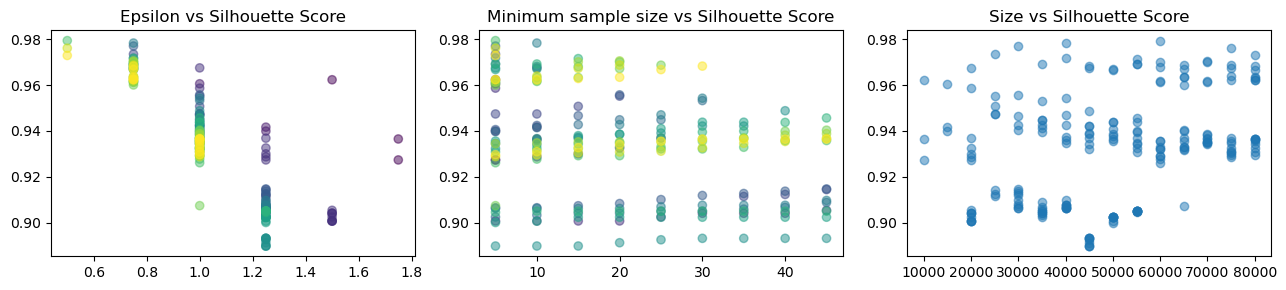

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(13,3))

axes[0].scatter(df['eps'], df['sil_score'], c=df['size'], alpha=0.5)
axes[0].set_title('Epsilon vs Silhouette Score')

axes[1].scatter(df['min_pts'], df['sil_score'], c=df['size'], alpha=0.5)
axes[1].set_title('Minimum sample size vs Silhouette Score')
axes[2].scatter(df['size'], df['sil_score'], alpha=0.5)
axes[2].set_title('Size vs Silhouette Score')
divider = make_axes_locatable(axes[0])

# Z = np.expand_dims(df['size'], axis=0)
# # cax = fig.add_axes([axes[0].get_position().x1+0.01,axes[0].get_position().y0,0.02,axes[0].get_position().height])
# pos = axes[0].imshow(Z, cmap='viridis')
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pos, ax=cax)

plt.show()

In [110]:
df.sort_values(by=['sil_score','eps','min_pts'], ascending=False)

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance,prop_noise
135,60000,5,0.50,2,58831,0.979335,euclidean,0.980517
61,40000,10,0.75,2,39216,0.978272,euclidean,0.980400
30,30000,5,0.75,2,29414,0.976978,euclidean,0.980467
176,75000,5,0.50,2,73546,0.976040,euclidean,0.980613
22,25000,5,0.75,2,24510,0.973467,euclidean,0.980400
...,...,...,...,...,...,...,...,...
91,45000,25,1.25,2,44002,0.892659,euclidean,0.977822
90,45000,20,1.25,2,44000,0.891375,euclidean,0.977778
89,45000,15,1.25,2,43998,0.889944,euclidean,0.977733
88,45000,10,1.25,2,43998,0.889944,euclidean,0.977733


Results show that from epsilon between 0.01 and 0.75, with mininum samples sizes of 5 and 10 obtain the best results overall, and with data greater than 30 000.
This is with euclidean distances

Now let's try with more granular measures between those values

In [105]:
min_pts_range = [min_pts for min_pts in range(5,11)]
min_pts_range

[5, 6, 7, 8, 9, 10]

In [106]:
eps_range = [round(e*0.1,3) for e in range(5,11)]
eps_range

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [107]:
print(len(min_pts_range), len(eps_range))

6 6


In [108]:
mod_paths[4:6]

['/home/miguel/Projects/tfm-nlp/models/dv_42_30000_300_15_1_20_1e-5.model',
 '/home/miguel/Projects/tfm-nlp/models/dv_42_35000_300_15_1_20_1e-5.model']

In [123]:
tmp_file = Path(data_dir,'dbscan_eval_2.csv')
if tmp_file.is_file():
    tmp_file.unlink()
else:
    print('No such file exists')

No such file exists


In [128]:
%%time
dbscan_eval(mod_paths[4:11], min_pts_range, eps_range, filename='dbscan_eval_2')

Evaluating for 30000 points
Evaluating for 35000 points
Evaluating for 40000 points
Evaluating for 45000 points
Evaluating for 50000 points
Evaluating for 55000 points
Evaluating for 60000 points
CPU times: user 8h 42min 56s, sys: 1h 11min 53s, total: 9h 54min 50s
Wall time: 1h 14min 26s


In [129]:
%%time
dbscan_eval(mod_paths[11:], min_pts_range, eps_range, filename='dbscan_eval_2')

Evaluating for 65000 points
Evaluating for 70000 points
Evaluating for 75000 points
Evaluating for 80000 points
Evaluating for 85000 points
Evaluating for 90000 points
Evaluating for 95000 points
CPU times: user 1d 2h 32min 38s, sys: 5h 11min 14s, total: 1d 7h 43min 52s
Wall time: 3h 58min 6s


In [130]:
df_2 = pd.read_csv(Path(data_dir,'dbscan_eval_2.csv'))
df_2['prop_noise'] = df_2['n_noise'].div(df_2['size'])
df_2 = df_2.dropna().reset_index(drop=True)

In [132]:
df_2.sort_values(by=['sil_score'], ascending=False)

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance,prop_noise
0,30000,5,0.7,2,29417,0.979761,euclidean,0.980567
1,30000,6,0.7,2,29417,0.979761,euclidean,0.980567
294,85000,7,0.5,2,83359,0.979630,euclidean,0.980694
293,85000,6,0.5,2,83359,0.979630,euclidean,0.980694
136,60000,6,0.5,2,58832,0.979571,euclidean,0.980533
...,...,...,...,...,...,...,...,...
165,60000,9,1.0,2,58725,0.927178,euclidean,0.978750
162,60000,6,1.0,2,58724,0.926633,euclidean,0.978733
161,60000,5,1.0,2,58723,0.926181,euclidean,0.978717
191,65000,5,1.0,3,63625,0.907508,euclidean,0.978846


In [7]:
min_pts_range = [min_pts for min_pts in range(5,11)]
min_pts_range

[5, 6, 7, 8, 9, 10]

In [8]:
eps_range = [round(e*0.01,3) for e in range(10,41,5)]
eps_range

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [13]:
%%time
dbscan_eval(mod_paths[4:11], min_pts_range, eps_range, distance='cosine', filename='dbscan_eval_3')

Evaluating for 30000 points
Evaluating for 35000 points
Evaluating for 40000 points
Evaluating for 45000 points
Evaluating for 50000 points
Evaluating for 55000 points
Evaluating for 60000 points
CPU times: user 4h 19min 31s, sys: 1h 34min 56s, total: 5h 54min 27s
Wall time: 53min 45s


In [16]:
def read_clust_results(file_path):
    df = pd.read_csv(Path(data_dir, file_path))
    df['prop_noise'] = df['n_noise'].div(df['size'])
    return df

In [17]:
df3 = read_clust_results('dbscan_eval_3.csv')

In [18]:
df3.shape

(294, 8)

In [19]:
df3 = df3.dropna()

In [23]:
df3.sort_values(by=['sil_score', 'prop_noise'], ascending=[True, True])

,size,min_pts,eps,n_cluster,n_noise,sil_score,distance,prop_noise
36,30000,5,0.40,48,8990,-0.086941,cosine,0.299667
72,35000,5,0.35,91,17101,-0.085614,cosine,0.488600
37,30000,6,0.40,42,9232,-0.082189,cosine,0.307733
73,35000,6,0.35,78,17360,-0.078719,cosine,0.496000
78,35000,5,0.40,30,8063,-0.074946,cosine,0.230371
...,...,...,...,...,...,...,...,...
129,45000,8,0.10,2,44886,0.677576,cosine,0.997467
130,45000,9,0.10,2,44886,0.677576,cosine,0.997467
172,50000,9,0.10,2,49900,0.693267,cosine,0.998000
173,50000,10,0.10,2,49901,0.694329,cosine,0.998020


### dist = 'euclidean'
min_samples = 10
epsilon = 1.85
db = DBSCAN(eps=epsilon, min_samples= min_samples, metric=dist).fit(data)
labels = db.labels_

In [76]:
%%time
epsilon = 1.85
db = DBSCAN(eps=epsilon, min_samples= min_samples, metric=dist).fit(data)

CPU times: user 4.58 s, sys: 559 ms, total: 5.14 s
Wall time: 650 ms


In [38]:
def get_cluster_colors(labs):
    colors = []
    for i in labs:
        if i == -1:
            colors.append((0, 0, 0, 1))
        else:
            colors.append(plt.cm.Set1(float(i)/10))
    return colors

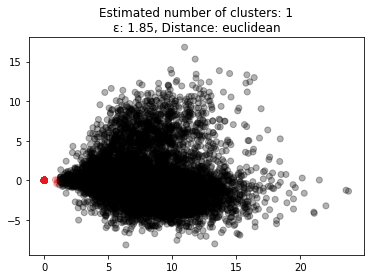

In [61]:
# Performing DBScan
dist = 'euclidean'
min_samples = 10
epsilon = 1.85
db = DBSCAN(eps=epsilon, min_samples= min_samples, metric=dist).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
colors = get_cluster_colors(labels)
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=colors, alpha=0.3)
plt.title(f'Estimated number of clusters: {n_clusters_}\n\N{GREEK SMALL LETTER EPSILON}: {epsilon}, Distance: {dist}')
plt.show()

## HDBSCAN

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=15, alpha=1.3).fit(data)
labels = clusterer.labels_

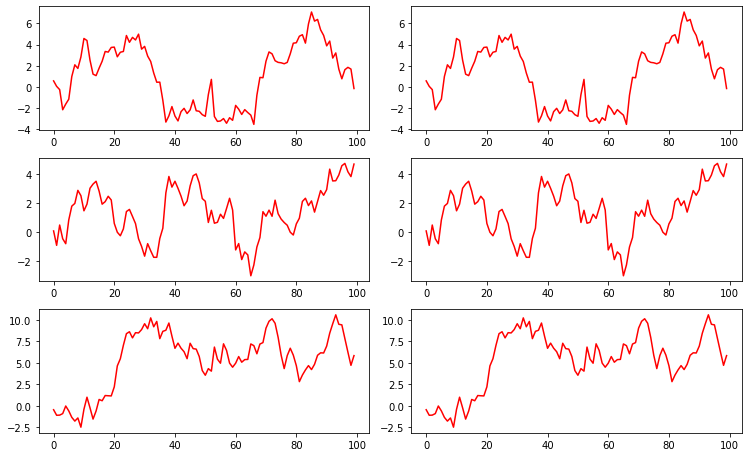

In [98]:

fig, axes = plt.subplots(3, 2)

""" Iterate column's axes"""
def iterate_columns(cols, x):
   for col in cols:
      col.plot(x, color='red')

""" Iterate row's axes"""
for row in axes:
   x = np.random.normal(0, 1, 100).cumsum()
   iterate_columns(row, x)

plt.show()